In [1]:
from code.agents import (
    PortfolioLifeCycleConsumerType,
)

import code.calibration.estimation_parameters as parameters

import numpy as np

from HARK.utilities import plot_funcs

***NOTE: using a 'quick fix' for an attribute error. See 'Error Notes' in EstimationParameter.py for further discussion.***


In [2]:
DiscFacAdj, CRRA = np.genfromtxt(
    "../tables/Portfolio_estimate_results.csv", skip_header=1, delimiter=","
)

In [3]:
portfolio_agent = PortfolioLifeCycleConsumerType(**parameters.init_consumer_objects)


portfolio_agent.CRRA = CRRA


portfolio_agent.DiscFac = [b * DiscFacAdj for b in parameters.DiscFac_timevary]

In [4]:
portfolio_agent.solve()

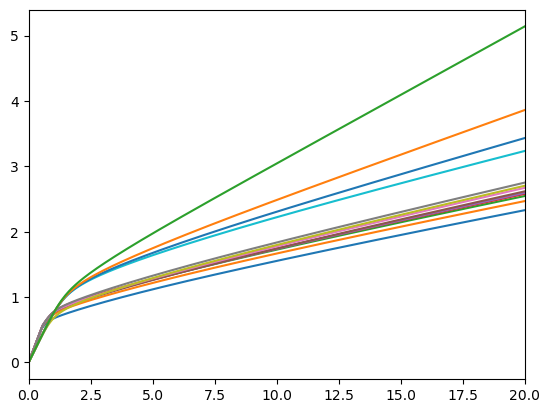

In [5]:
plot_funcs([sol.cFunc for sol in portfolio_agent.solution[:-1:5]], 0, 20)

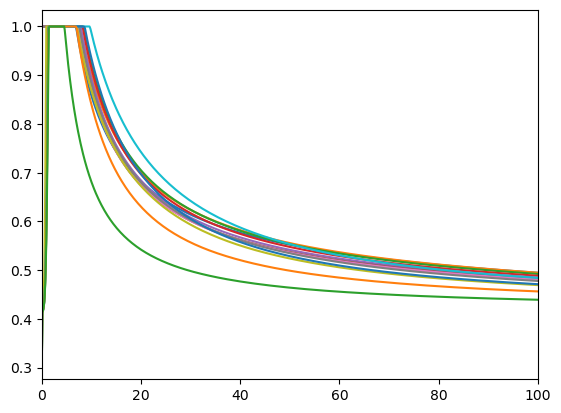

In [6]:
plot_funcs([sol.ShareFuncAdj for sol in portfolio_agent.solution[:-1:5]], 0, 100)